# Multi-Class Classification with Transformer Encoder

## 1. Loading helper modules & functions

In [1]:
%load_ext autoreload
%autoreload 2
import torch as T
import torch.nn as nn
import pandas as pd
import numpy as np
import h5py
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import torchinfo
import os
# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"  # Arrange GPU devices starting from 0
# os.environ["CUDA_VISIBLE_DEVICES"]= "0,1"  # Set the GPU 2 to use
device = T.device("cuda" if T.cuda.is_available() else "cpu")
device2 = T.device("cuda:1" if T.cuda.is_available() else "cpu")
# device = T.device("cpu")
# from encoding.parallel import DataParallelModel, DataParallelCriterion
from torchmetrics import MetricCollection
from torchmetrics.classification import MulticlassAccuracy, MulticlassPrecision, MulticlassRecall, MulticlassF1Score, MulticlassConfusionMatrix
metric_collection = MetricCollection([
    # MulticlassAccuracy(num_classes=4, average="none").to(device),
    MulticlassPrecision(num_classes=4, average="none").to(device),
    MulticlassRecall(num_classes=4, average="none").to(device),
    MulticlassF1Score(num_classes=4, average="none").to(device),
])
metric_collection_weighted = MetricCollection([
    # MulticlassAccuracy(num_classes=4, average="weighted").to(device),
    MulticlassPrecision(num_classes=4, average="weighted").to(device),
    MulticlassRecall(num_classes=4, average="weighted").to(device),
    MulticlassF1Score(num_classes=4, average="weighted").to(device),
])
import sklearn.datasets
from sklearn.model_selection import train_test_split
# import umap
# import umap.plot
import shap
import scipy as sp
# import transformers
print("Pytorch version:", T.__version__, "CUDA version:", T.version.cuda, "cuDNN version:", T.backends.cudnn.version())
print("device:", device, T.cuda.get_device_name(0), ", device2:", device2, T.cuda.get_device_name(1))

Pytorch version: 1.12.1 CUDA version: 11.3 cuDNN version: 8302
device: cuda NVIDIA RTX A6000 , device2: cuda:1 NVIDIA RTX A6000


## 2. Implementing backbone of Transformer-based Classifier

In [2]:
# feature 개수 확인 및 설정
hf = h5py.File('STAD_Dataset3_ALL_exam.h5', 'r')
X = np.array(hf.get('X'))
Y = np.array(hf.get('Y'))
print('X.shape :', X.shape, ', X.dtype :', X.dtype)
print('Y.shape :', Y.shape, '     , Y.dtype :', Y.dtype)
hf.close()

n_feature = X.shape[1]
print("\nThe number of feature :", n_feature)

X.shape : (407, 1501) , X.dtype : float64
Y.shape : (407,)      , Y.dtype : int8

The number of feature : 1501


In [3]:
class STAD_Dataset(T.utils.data.Dataset):
    def __init__(self, src_file):
        hf = h5py.File(src_file, 'r')
        if 'X_Train' in hf.keys() :
            # X = np.array(hf.get('X_Train')).astype('int64')
            X = np.array(hf.get('X_Train'))
            Y = np.array(hf.get('Y_Train')).astype('int8')
        else :
            # X = np.array(hf.get('X_Test')).astype('int64')
            X = np.array(hf.get('X_Test'))
            Y = np.array(hf.get('Y_Test')).astype('int8')
        hf.close()

        # self.x_data = T.tensor(X, dtype=T.int64).to(device)
        self.x_data = T.tensor(X, dtype=T.float32).to(device)
        self.y_data = T.tensor(Y, dtype=T.int64).to(device)  

    def __len__(self):
        return len(self.x_data)

    def __getitem__(self, idx):
        x = self.x_data[idx]
        y = self.y_data[idx] 
        return x, y  

In [4]:
class PositionalEncoding(T.nn.Module):  
    def __init__(self, d_model: int, dropout: float=0.1, max_len: int=n_feature):
        super(PositionalEncoding, self).__init__()  
        self.dropout = T.nn.Dropout(p=dropout)
        pe = T.zeros(max_len, d_model)  
        position = T.arange(0, max_len, dtype=T.float32).unsqueeze(1)
        div_term = T.exp(T.arange(0, d_model, 2).float() * (-np.log(10_000.0) / d_model))
        pe[:, 0::2] = T.sin(position * div_term)
        pe[:, 1::2] = T.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)  # 이게 없으면 나중에 forward 에서 pe값을 못 찾아 에러남

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

In [5]:
# E = number of cases that all features can express in integer (feature=token) 
# D = #Embedding Dimension ; I = #input features ; F = #fc1 layer hidden nodes ; drop = dropout rate
E = 320 ; D = 8 ; I = n_feature ; F = 8 ; drop = 0.1
class Transformer_Classifier(T.nn.Module):  # 1501 -> 12008 -> Transformer -> FC -> 4
    def __init__(self):
        super(Transformer_Classifier, self).__init__() 
        # numeric pseudo-embedding, dim=D
        # self.embed = Special_Embedding_Layer(I, I*D)  # I input features, each goes to D 
        self.embed = T.nn.Embedding(E, D)  # I input features, each goes to D
        self.pos_enc = PositionalEncoding(D, dropout=drop)  # positional embedding
        self.enc_layer = T.nn.TransformerEncoderLayer(d_model=D, nhead=4, dim_feedforward=D, 
                         dropout=drop, batch_first=True)  # d_model should be divisible by nhead
        self.trans_enc = T.nn.TransformerEncoder(self.enc_layer, num_layers=3)  # default 6 layers 
        # STAD Dataset has I input features per each sample
        self.dropout = nn.Dropout(drop)
        # self.fc1 = T.nn.Linear(D*I, F)  # F hidden nodes
        # self.fc2 = T.nn.Linear(F, 4)    # 4 classes
        self.fc3 = T.nn.Linear(D*I, 4)    # 4 classes (GX, G1, G2, G3)

    def forward(self, x):
        # x = I input features, fixed length
        z = self.embed(x.int())  # I inputs to I*D embeds
        z = z.reshape(-1, I, D) 
        z = self.pos_enc(z) 
        z = self.trans_enc(z) 
        z = z.reshape(-1, D*I)  # torch.Size([batch_size, D*I])
        # z = self.dropout(z)
        # z = self.fc1(z)
        # z = T.tanh(z)
        z = self.dropout(z)
        z = self.fc3(z)
        z = T.log_softmax(z, dim=1)  # later followed by NLL Loss()
        return z
max_F1 = 0

## 3. Training model

### 3-0. Data Random Splitting

In [6]:
# 1. Train : Test 를 레이블 비율을 균등하게 유지하면서 8 : 2로 랜덤하게 나눔
X_Train, X_Test, Y_Train, Y_Test = train_test_split(X, Y, test_size=0.2, stratify=Y)

# 2. Train 데이터 파일로 저장
hf = h5py.File('STAD_Dataset3_Train_exam.h5', 'w')
hf.create_dataset('X_Train', data=X_Train)
hf.create_dataset('Y_Train', data=Y_Train)
hf.close()
# 3. Test 데이터 파일로 저장 
hf = h5py.File('STAD_Dataset3_Test_exam.h5', 'w')
hf.create_dataset('X_Test', data=X_Test)
hf.create_dataset('Y_Test', data=Y_Test)
hf.close()

print('X_Train.shape : ', X_Train.shape)
print('Y_Train.shape : ', Y_Train.shape)
print('X_Test.shape  : ', X_Test.shape)
print('Y_Test.shape  : ', Y_Test.shape)
"Y_Test", Y_Test # 매번 랜덤으로 들어가는 지 확인

X_Train.shape :  (325, 1501)
Y_Train.shape :  (325,)
X_Test.shape  :  (82, 1501)
Y_Test.shape  :  (82,)


('Y_Test',
 array([2, 3, 2, 2, 3, 3, 3, 2, 2, 2, 3, 3, 3, 3, 3, 2, 2, 3, 2, 3, 3, 1,
        2, 3, 2, 3, 1, 3, 3, 2, 3, 3, 3, 2, 2, 2, 3, 3, 2, 3, 3, 0, 3, 3,
        0, 3, 2, 2, 3, 3, 2, 3, 3, 3, 3, 2, 3, 3, 3, 3, 2, 3, 2, 3, 3, 3,
        3, 3, 2, 2, 2, 2, 3, 3, 3, 3, 2, 2, 3, 2, 2, 3], dtype=int8))

### 3-1. Lodaing Dataset

In [12]:
# 0. setup
print("Making tensor dataset of STAD samples on device", device, T.cuda.get_device_name(0))
np.random.seed(1)  
T.manual_seed(1)  

# 1. create Dataset
train_file = "./STAD_Dataset3_Train_exam.h5"
train_ds = STAD_Dataset(train_file)
print(" ", len(train_ds), "training dataset created from an h5 file")

test_file = "./STAD_Dataset3_Test_exam.h5"
test_ds = STAD_Dataset(test_file)
print(" ", len(test_ds), "test dataset created from an h5 file")

bat_size = 8
train_ldr = T.utils.data.DataLoader(train_ds, batch_size=bat_size, shuffle=True)
print("  Dataloader for training prepared with batch_size", bat_size)
# test_ldr = T.utils.data.DataLoader(test_ds, batch_size=2, shuffle=False)

Making tensor dataset of STAD samples on device cuda NVIDIA RTX A6000
  325 training dataset created from an h5 file
  82 test dataset created from an h5 file
  Dataloader for training prepared with batch_size 8


### 3-2. Training model

Creating Transformer network...
Preparation for model training complete.

bat_size =   8 
loss = NLLLoss()
optimizer =  Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    eps: 1e-08
    foreach: None
    initial_lr: 0.0001
    lr: 0.0001
    maximize: False
    weight_decay: 0.1
)
max_epochs =  18 

Starting training
epoch =    1  |  loss =   5.2400  |  lr = 0.00010000
epoch =    2  |  loss =   4.4398  |  lr = 0.00009900
epoch =    3  |  loss =   3.5121  |  lr = 0.00009801
epoch =    4  |  loss =   3.0754  |  lr = 0.00009703
epoch =    5  |  loss =   2.6344  |  lr = 0.00009606
epoch =    6  |  loss =   2.1882  |  lr = 0.00009510
epoch =    7  |  loss =   1.6720  |  lr = 0.00009415
epoch =    8  |  loss =   1.5096  |  lr = 0.00009321
epoch =    9  |  loss =   1.3328  |  lr = 0.00009227
epoch =   10  |  loss =   1.0506  |  lr = 0.00009135
epoch =   11  |  loss =   0.8809  |  lr = 0.00009044
epoch =   12  |  loss =   0.7908  |  lr = 0.00008953
ep

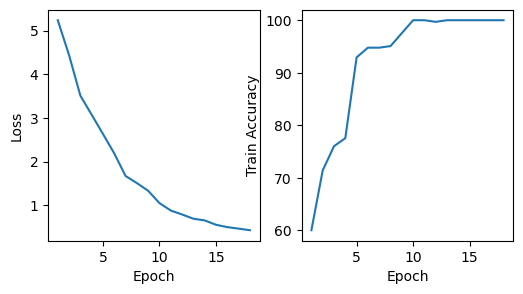

In [13]:
print("Creating Transformer network...")
# net = Transformer_Classifier().to(device)
net = nn.DataParallel(Transformer_Classifier()).to(device)
# net = DataParallelModel(Transformer_Classifier()).to(device) # for Multi-GPU 
# net.double() # 모델 내 데이터들을 전체적으로 float32에서 float64로 만들어 줌. 대신 훈련시간 6배 더 걸림.
# net.half() # float16으로 만들어 주어서 정말 GPU가 반만 드는데 loss가 줄어들지 않는 경우가 다반사
print("Preparation for model training complete.")

max_epochs = 18
ep_log_interval = 1
lrn_rate = 0.0001

loss_func = T.nn.NLLLoss()  # assumes log-softmax()
# loss_func = DataParallelCriterion(T.nn.NLLLoss())  # assumes log-softmax()
# optimizer = T.optim.SGD(net.parameters(), lr=lrn_rate)
optimizer = T.optim.Adam(net.parameters(), lr=lrn_rate, weight_decay=0.1)
scheduler = T.optim.lr_scheduler.LambdaLR(optimizer=optimizer, lr_lambda=lambda epoch: 0.99 ** epoch, last_epoch=-1, verbose=False)

print("\nbat_size = %3d " % bat_size)
print("loss = " + str(loss_func))
print("optimizer = ", optimizer)
# print("lrn_rate = %0.5f " % lrn_rate)
print("max_epochs = %3d " % max_epochs)

print("\nStarting training")
net.train()  # set mode

loss_list = []
accuracy_list = []
test_accuracy_list = []
for epoch in range(0, max_epochs):
    ep_loss = 0.0  # for one full epoch
    for (batch_idx, batch) in enumerate(train_ldr):
        (X, y) = batch  # X = pixels, y = target labels
        optimizer.zero_grad()
        # with T.autocast(device_type="cuda"): # for auto-mixed precision
        oupt = net(X)
        loss_val = loss_func(oupt, y)  # a tensor
        # loss_val = loss_func(oupt, (y[0:5], y[5:10].to(device2)))  # a tuple tensor for DataParallelCriterion
        ep_loss += loss_val.item()  # accumulate
        loss_val.backward()  # compute grads
        optimizer.step()     # update weights
    if epoch % ep_log_interval == 0:
        print("epoch = %4d  |  loss = %8.4f  |  lr = %8.8f" % (epoch+1, ep_loss/bat_size, optimizer.param_groups[0]['lr']))
        # net.eval()
    scheduler.step()

    # train loss & accuracy 그래프를 그리기 위한 코드
    with T.no_grad(): 
        total = 0
        correct=0
        for X, Y in train_ldr:
            outputs = net(X)
            _,predict = T.max(outputs.data, 1)
            total += Y.size(0)
            correct += (predict==Y).sum()
    avg_cost = ep_loss / bat_size
    accuracy = 100 * correct / total
    loss_list.append(avg_cost)
    accuracy_list.append(accuracy.cpu().numpy())

    # # test loss & accuracy 그래프를 그리기 위한 코드
    # with T.no_grad(): 
    #     total = 0
    #     correct=0
    #     for X, Y in test_ldr:
    #         outputs = net(X)
    #         _,predict = T.max(outputs.data, 1)
    #         total += Y.size(0)
    #         correct += (predict==Y).sum()
    # accuracy = 100*correct / total
    # test_accuracy_list.append(accuracy.cpu().numpy())

print("Done ") 

# 훈련과정 전반에 걸친 Loss & Accuracy 그래프
epochs = np.arange(1, max_epochs+1)
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(epochs, loss_list)
plt.subplot(1,2,2)
plt.xlabel('Epoch')
plt.ylabel('Train Accuracy')
plt.plot(epochs, accuracy_list)
# plt.subplot(1,3,3)
# plt.xlabel('Epoch')
# plt.ylabel('Test Accuracy')
# plt.plot(epochs, test_accuracy_list)
# plt.show()

## 4. Evaluating model

In [14]:
print("Train Dataset 통합 평가지수(Precision/Recall/F1Score)")
net.eval()
with T.no_grad():
    output_train = net(train_ds.x_data)
target_train = train_ds.y_data
preds_train  = output_train.argmax(dim=1, keepdim=True).squeeze(1)
metric_collection_weighted(preds_train, target_train)

Train Dataset 통합 평가지수(Precision/Recall/F1Score)


{'MulticlassPrecision': tensor(1., device='cuda:0'),
 'MulticlassRecall': tensor(1., device='cuda:0'),
 'MulticlassF1Score': tensor(1., device='cuda:0')}

In [15]:
print("Test Dataset 통합 평가지수(Precision/Recall/F1Score)")
net.eval()
with T.no_grad():
    output_test = net(test_ds.x_data)
target_test = test_ds.y_data
preds_test  = output_test.argmax(dim=1, keepdim=True).squeeze(1)
metric_collection_weighted(preds_test, target_test)

Test Dataset 통합 평가지수(Precision/Recall/F1Score)


{'MulticlassPrecision': tensor(0.5638, device='cuda:0'),
 'MulticlassRecall': tensor(0.5854, device='cuda:0'),
 'MulticlassF1Score': tensor(0.5734, device='cuda:0')}

### 4-1. Evaluating model with Train Dataset

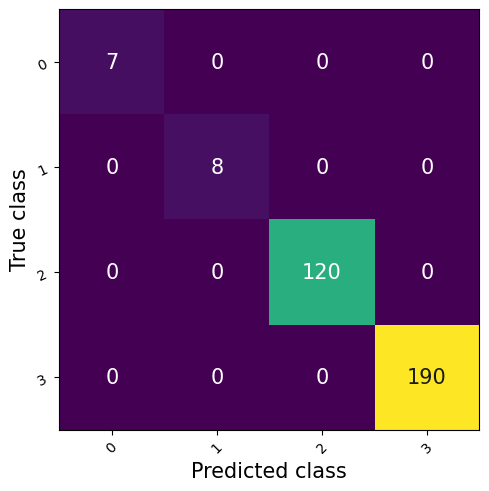

In [16]:
target_train = train_ds.y_data
preds_train  = output_train.argmax(dim=1, keepdim=True).squeeze(1)
metric_train = MulticlassConfusionMatrix(num_classes=4).to(device)
metric_train.update(preds_train, target_train)
fig_, ax_ = metric_train.plot()

In [17]:
print("Train Dataset 세부 평가지수(레이블 각각의 Precision/Recall/F1Score)")
metric_collection(preds_train, target_train)

Train Dataset 세부 평가지수(레이블 각각의 Precision/Recall/F1Score)


{'MulticlassPrecision': tensor([1., 1., 1., 1.], device='cuda:0'),
 'MulticlassRecall': tensor([1., 1., 1., 1.], device='cuda:0'),
 'MulticlassF1Score': tensor([1., 1., 1., 1.], device='cuda:0')}

### 4-2. Evaluating model with Test Dataset

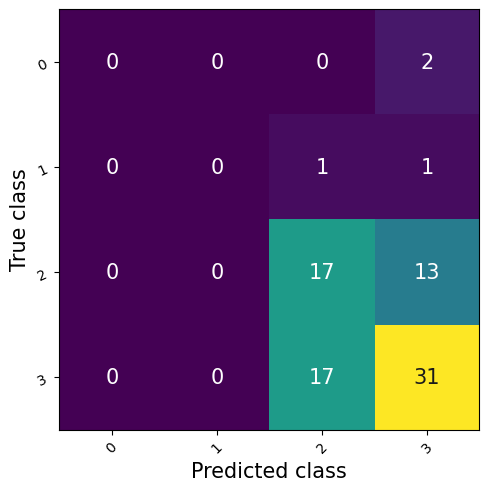

In [18]:
target_test = test_ds.y_data
preds_test  = output_test.argmax(dim=1, keepdim=True).squeeze(1)
metric_test = MulticlassConfusionMatrix(num_classes=4).to(device)
metric_test.update(preds_test, target_test)
fig_, ax_ = metric_test.plot()

In [19]:
print("Train Dataset 세부 평가지수(레이블 각각의 Precision/Recall/F1Score)")
metric_collection(preds_test, target_test)

Train Dataset 세부 평가지수(레이블 각각의 Precision/Recall/F1Score)


{'MulticlassPrecision': tensor([0.0000, 0.0000, 0.4857, 0.6596], device='cuda:0'),
 'MulticlassRecall': tensor([0.0000, 0.0000, 0.5667, 0.6458], device='cuda:0'),
 'MulticlassF1Score': tensor([0.0000, 0.0000, 0.5231, 0.6526], device='cuda:0')}

## 5. Save model

In [ ]:
# # 단일 GPU에서 훈련시킨 경우
# file_name = "./Model_save/exam.pt"
# T.save(net.state_dict(), file_name)  
# print("\ntrained model state saved")


trained model state saved


In [36]:
# 여러 GPU에서 DataParallel로 훈련시키고 나서 weight를 통합해서 저장하는 방법 
# (나중에 불러낸 후 단일 GPU에서 추론 해야만 할 때를 대비하기 위함임) 
# file_name = "./Model_save/exam.pt"
# T.save(net.module.state_dict(), file_name)  
# print("\ntrained model state saved")

current_F1 = MulticlassF1Score(num_classes=4, average="weighted").to(device)(preds_test, target_test)
if current_F1 > max_F1 :
    max_F1 = current_F1
    file_name = "./Model_save/exam.pt"
    T.save(net.module.state_dict(), file_name)  
    print("\ntrained model state saved")


trained model state saved


## 6. Visualize the latent space of networks using UMAP

### 6-3. Visualizing network

#### 6-3-4. Fully-Connected Layer1 before & after training

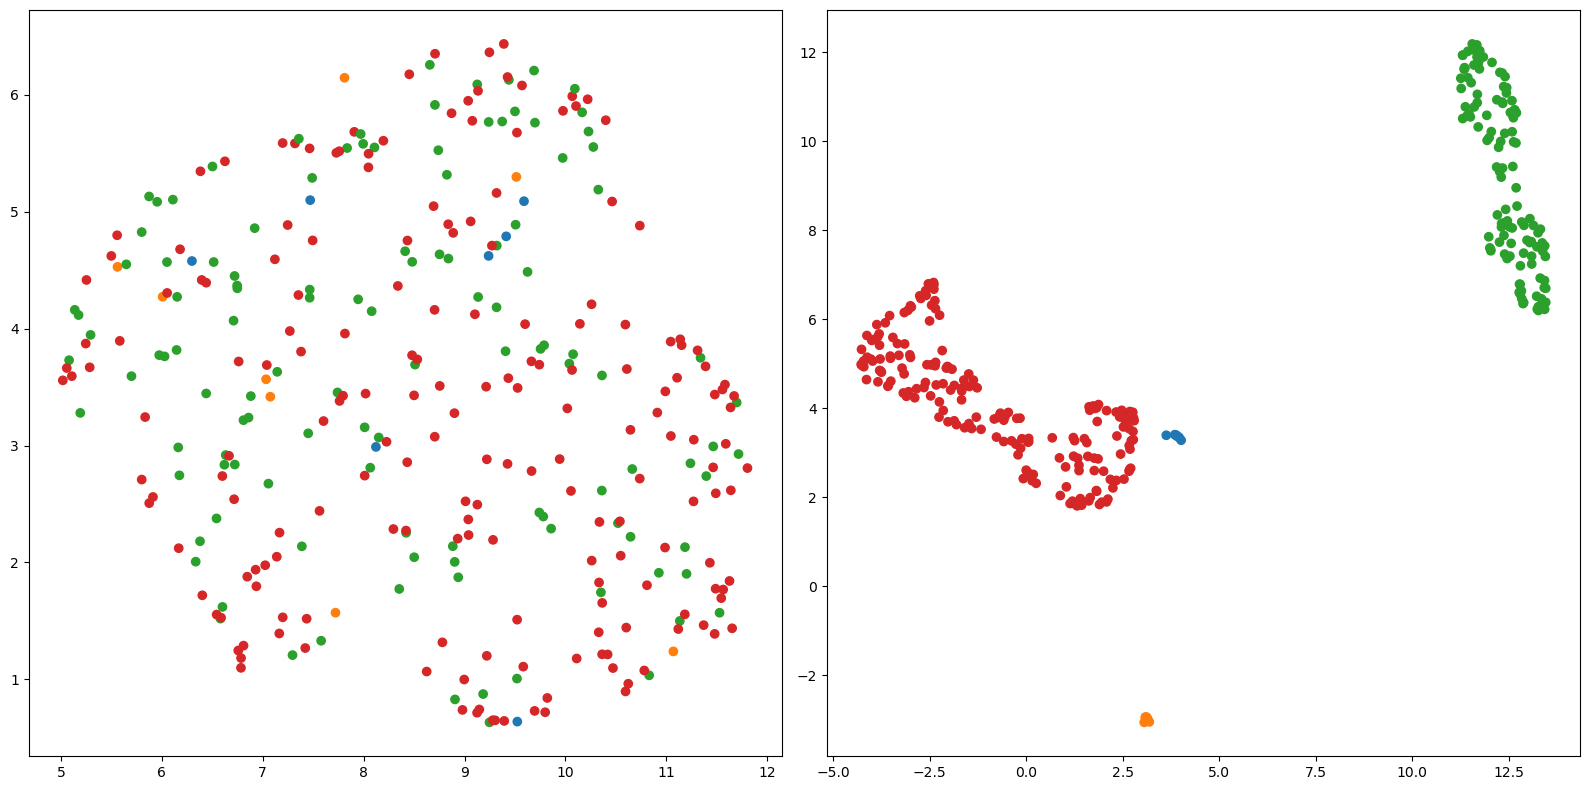

In [ ]:
# # Train Set
# fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
# axes[0].scatter(Uembedding_fc3_output_before[:, 0], Uembedding_fc3_output_before[:, 1], c=[sns.color_palette()[x] for x in Y_Train])
# axes[1].scatter(Uembedding_fc3_output_after[:, 0], Uembedding_fc3_output_after[:, 1], c=[sns.color_palette()[x] for x in Y_Train])
# plt.tight_layout()
# plt.show()
# plt.close(fig)

## 7. Analizing the degree of contribution of each feature using SHAP

#### 7-1. 트랜스포머 인코더 feature 번호가 어떤 유전자ID였는지 참조할 리스트 만들고 각 유전자ID에 해당하는 gene symbol 리스트 만들기

In [ ]:
df_All = pd.read_pickle('xy_STAD-related-only3_exam_features_removed.pkl')
df_X = df_All.drop(labels=['neoplasm_histologic_grade','submitter_id.samples'], axis=1)
STAD_related_geneID_list = df_X.columns

df = pd.read_excel('GASCplusPHGDH_1554.xlsx')

STAD_related_gene_symbol_list = []
for gene_ID in STAD_related_geneID_list:
    for i, E_ID in enumerate(df['Ensembl ID']):
        if gene_ID == E_ID:
            STAD_related_gene_symbol_list.append(df['Gene Symbol'][i])
print("Length of the gene symbol list :", len(STAD_related_gene_symbol_list))

Length of the gene symbol list : 1501


### 7-2. Plotting shapley values using Gradient Explainer with transformer

In [41]:
# 훈련했던 모델 불러오기
model = Transformer_Classifier().to(device)
model.load_state_dict(T.load('./exam.pt'))

# 복잡한 트랜스포머 모델을 설명하기 위한 작은 축소 모델 만들기 
ge = shap.GradientExplainer((model, model.trans_enc), train_ds.x_data)

# 축소모델로 shapley value 구하기
G_shap_values = ge.shap_values(train_ds.x_data[0:1])
len(G_shap_values), G_shap_values[3].shape, G_shap_values[3][0].shape, G_shap_values[3][0].T.shape

(4, (1, 1501, 8), (1501, 8), (8, 1501))

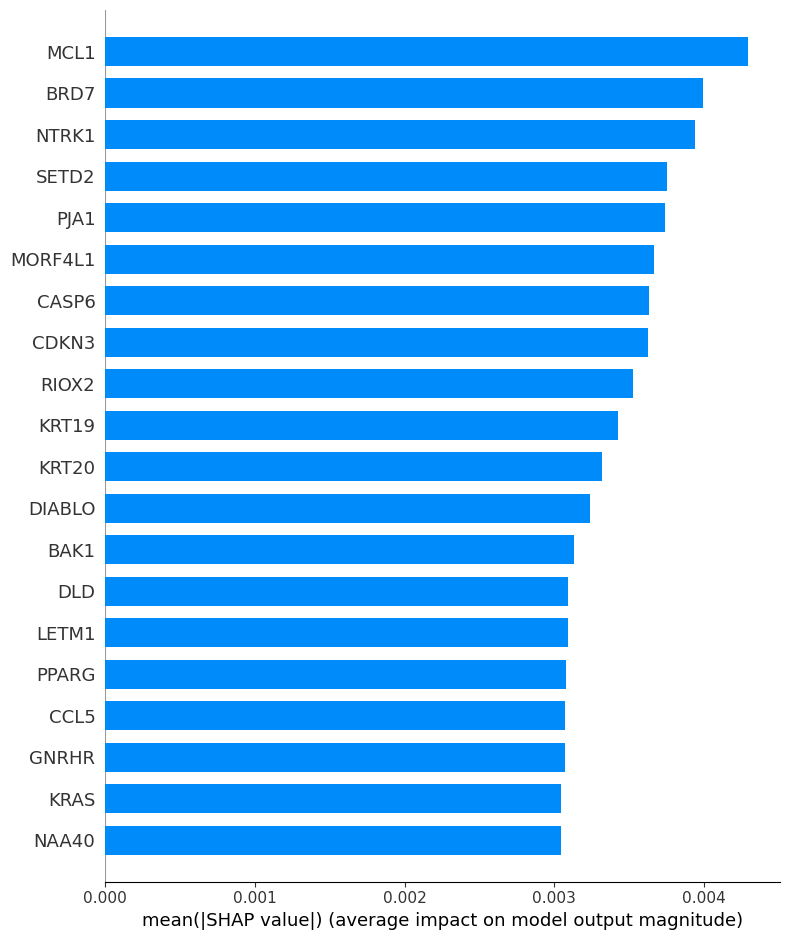

In [42]:
# Shapley value 로 각 feature 들의 (모델추론결과(분류)에의) 기여도(영향력) 그래프 그리기
shap.summary_plot(G_shap_values[3][0].T, plot_type='bar', features=STAD_related_gene_symbol_list)

##### 7-3. 악성종양 분류에의 기여도가 가장 큰 20개의 유전자를 뺀 데이터 파일 만들기 

In [ ]:
# 위 그래프 상황 데이터프레임으로 재현
shap_df = pd.DataFrame(data=G_shap_values[3][0])
symbol_df = pd.DataFrame(data=STAD_related_gene_symbol_list)
symbol_shap_df = pd.concat([symbol_df, shap_df], axis=1)
mean_df = pd.DataFrame(np.mean(np.abs(G_shap_values[3][0]), axis=1))
symbol_shap_mean_df = pd.concat([symbol_shap_df, mean_df], axis=1)
symbol_shap_mean_df.columns=['G_symbol','head1','head2','head3','head4','head5','head6','head7','head8','abs_mean']
symbol_shap_mean_df_sorted = symbol_shap_mean_df.sort_values(by=['abs_mean'], ascending=[False])
symbol_shap_mean_df_sorted

,G_symbol,head1,head2,head3,head4,head5,head6,head7,head8,abs_mean
682,MCL1,0.000076,0.007051,0.000750,1.657061e-02,0.000489,2.226042e-03,0.001357,-0.005816,0.004292
905,BRD7,-0.000750,0.009022,0.001532,1.022532e-02,0.001398,3.027652e-03,0.000753,-0.005209,0.003990
1189,NTRK1,0.000192,-0.013585,-0.000054,-8.765909e-03,-0.002660,-1.559769e-04,-0.000434,0.005662,0.003939
1081,SETD2,-0.002457,0.009220,0.000190,1.195815e-02,0.001051,-2.385696e-03,0.002589,0.000184,0.003754
1079,PJA1,-0.000004,0.012853,0.000229,5.813552e-03,-0.000199,6.826772e-04,0.001622,-0.008504,0.003739
...,...,...,...,...,...,...,...,...,...,...
328,CCND1,-0.000002,-0.000530,0.000369,-3.016621e-04,0.000193,2.650502e-04,-0.000215,0.000709,0.000323
1088,RNF32-DT,0.000046,0.000586,-0.000166,3.442681e-04,-0.000174,7.959033e-04,0.000118,0.000051,0.000285
225,PYGB,0.000246,0.000337,0.000126,-1.128526e-03,-0.000072,7.198324e-07,-0.000077,0.000109,0.000262
1314,MIR30C1,-0.000017,-0.000411,-0.000120,2.670194e-04,-0.000098,6.107926e-04,-0.000106,0.000247,0.000235


In [ ]:
# 상위 20개의 Gene symbol 에 해당하는 Ensenbl ID를 GASCplusPHGDH_1554 df 에서 찾아 리스트로 만들기  
ENSG_IDs_to_remove = []
for G in symbol_shap_mean_df_sorted.iloc[0:20]['G_symbol']:
    ENSG_IDs_to_remove.append(df[df['Gene Symbol']==G]['Ensembl ID'].to_string()[-15:])
ENSG_IDs_to_remove

['ENSG00000143384',
 'ENSG00000166164',
 'ENSG00000198400',
 'ENSG00000181555',
 'ENSG00000181191',
 'ENSG00000185787',
 'ENSG00000138794',
 'ENSG00000100526',
 'ENSG00000170854',
 'ENSG00000171345',
 'ENSG00000171431',
 'ENSG00000184047',
 'ENSG00000030110',
 'ENSG00000091140',
 'ENSG00000168924',
 'ENSG00000132170',
 'ENSG00000271503',
 'ENSG00000109163',
 'ENSG00000133703',
 'ENSG00000110583']

In [62]:
# 전체 데이터프레임으로부터 위 리스트의 요소가 컬럼이름인 데이터를 제거한 데이터프레임 만들기
df_All_features_removed = df_All.drop(labels=ENSG_IDs_to_remove, axis=1)
df_All_features_removed

,ENSG00000001036,ENSG00000001626,ENSG00000002330,ENSG00000003400,ENSG00000003402,ENSG00000005007,ENSG00000005156,ENSG00000005175,ENSG00000005194,ENSG00000005844,...,ENSG00000278910,ENSG00000280924,ENSG00000280997,ENSG00000281183,ENSG00000281189,ENSG00000281202,ENSG00000281406,ENSG00000281450,neoplasm_histologic_grade,submitter_id.samples
318,20.219629,16.825263,19.121479,17.287974,16.630257,17.568893,15.572426,16.993762,18.063461,15.244971,...,11.962227,13.237309,8.099240,15.439994,12.557625,0.000000,14.470708,0.000000,G1,TCGA-KB-A93H-01A
317,18.819095,12.144605,17.963353,16.261201,18.064107,18.698039,15.809532,16.613230,17.294052,15.892170,...,0.000000,11.723755,10.902820,15.902137,11.159664,0.000000,13.233482,8.801656,G1,TCGA-KB-A93G-01A
132,19.807727,17.048517,19.515146,17.236227,16.513151,18.753454,16.319948,16.776418,18.327796,15.494267,...,0.000000,13.746728,8.880671,13.426548,14.626484,0.000000,16.505431,0.000000,G1,TCGA-CD-5800-01A
179,18.941061,15.740072,19.171449,16.252021,17.308548,18.667955,15.786658,16.111774,18.430531,16.296577,...,0.000000,13.519727,0.000000,15.516455,12.852409,7.879561,16.408713,8.441310,G1,TCGA-CG-5719-01A
258,19.919778,18.664863,18.456981,17.296716,16.551752,18.715583,16.050815,17.181970,17.770386,13.915716,...,0.000000,12.874540,9.264021,15.442020,13.462183,0.000000,14.359035,0.000000,G1,TCGA-HU-8244-01A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82,18.749838,14.442284,18.851856,16.423086,17.029071,18.415530,16.069512,17.105799,17.426681,15.877429,...,11.912352,11.394259,7.374729,15.455789,12.198967,7.031628,13.265510,10.392719,GX,TCGA-BR-8297-01A
378,20.160689,19.391947,17.841738,17.806221,17.092400,18.839794,16.161789,17.072886,17.125779,16.660077,...,11.641512,10.708630,11.487912,14.583587,13.082237,0.000000,15.675195,10.314506,GX,TCGA-VQ-A91S-01A
344,19.631296,11.517487,18.765269,17.731691,17.073518,18.193675,15.092689,16.983539,17.902584,15.178758,...,13.597188,12.146249,0.000000,15.329461,9.124790,0.000000,14.680185,10.784776,GX,TCGA-SW-A7EA-01A
50,19.331497,17.675182,18.370031,16.306453,17.176000,20.383370,15.860547,16.679588,18.546336,14.489921,...,10.363710,12.166602,0.000000,14.522243,13.625953,9.794749,14.882827,0.000000,GX,TCGA-BR-7197-01A


In [105]:
df_All_features_removed.to_pickle('./xy_STAD-related-only3_exam_features_removed.pkl')